In [76]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=Warning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Load the dataset

In [77]:
data = pd.read_csv("ai4i2020.csv")

print(data.shape)

#Compute the mean of each column
print(data.mean())
print(data.std())

# show the first few examples (rows) from the dataset 
data.head()

(10000, 14)
UDI                        5000.50000
Air temperature [K]         300.00493
Process temperature [K]     310.00556
Rotational speed [rpm]     1538.77610
Torque [Nm]                  39.98691
Tool wear [min]             107.95100
Machine failure               0.03390
TWF                           0.00460
HDF                           0.01150
PWF                           0.00950
OSF                           0.00980
RNF                           0.00190
dtype: float64
UDI                        2886.895680
Air temperature [K]           2.000259
Process temperature [K]       1.483734
Rotational speed [rpm]      179.284096
Torque [Nm]                   9.968934
Tool wear [min]              63.654147
Machine failure               0.180981
TWF                           0.067671
HDF                           0.106625
PWF                           0.097009
OSF                           0.098514
RNF                           0.043550
dtype: float64


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Visualizing data

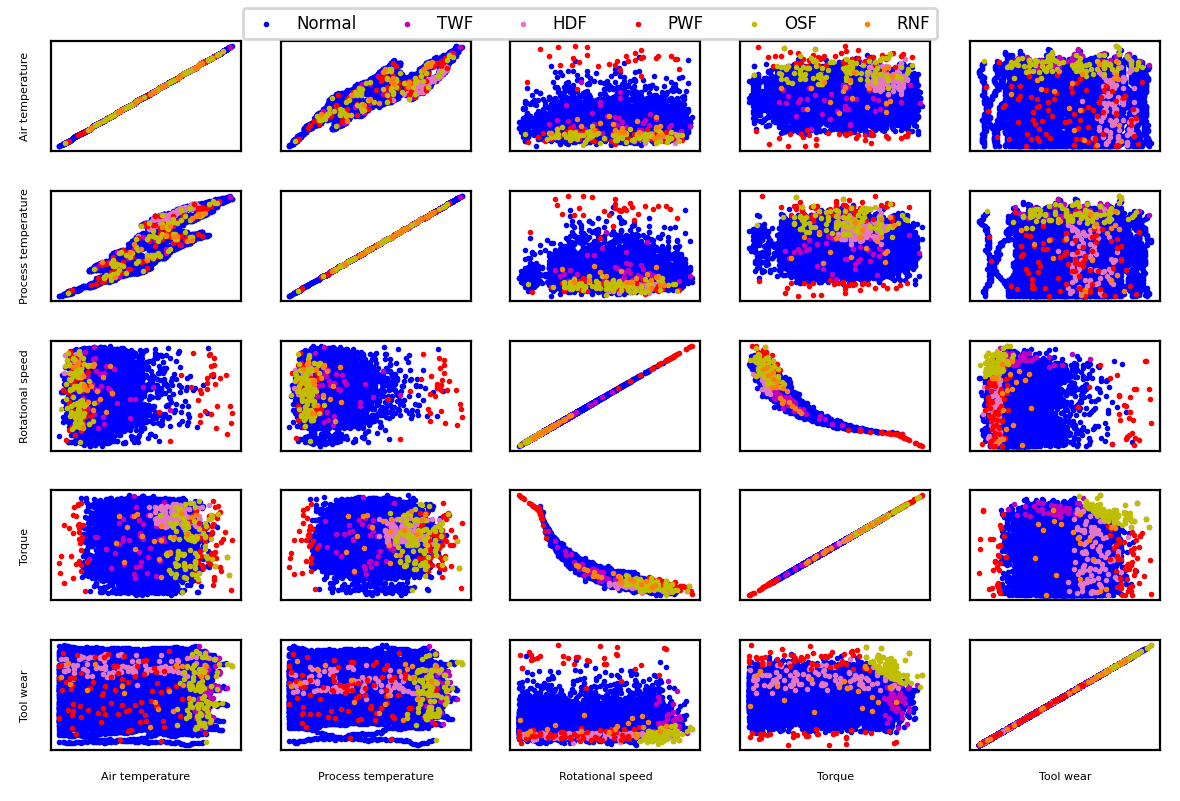

In [78]:
plt.figure(figsize=(6,4), dpi=200)
rows, cols = 5, 5
counter = 1
handle_labels = None
for i in range(3, 8):
    for j in range(3, 8):
        ax = plt.subplot(rows, cols, counter)
        counter += 1

        failures = data.loc[data["Machine failure"] == 1]
        twf = data.loc[data["TWF"] == 1]
        hdf = data.loc[data["HDF"] == 1]
        pwf = data.loc[data["PWF"] == 1]
        osf = data.loc[data["OSF"] == 1]
        rnf = data.loc[data["RNF"] == 1]
        normal = data.loc[data["Machine failure"] == 0]

        ax.scatter(normal.iloc[:,i], normal.iloc[:,j], 1, "b", label="Normal")
        #ax.scatter(failures.iloc[:,i], failures.iloc[:,j], 1, "r")
        ax.scatter(twf.iloc[:,i], twf.iloc[:,j], 1, "m", label="TWF")
        ax.scatter(hdf.iloc[:,i], hdf.iloc[:,j], 1, "tab:pink", label="HDF")
        ax.scatter(pwf.iloc[:,i], pwf.iloc[:,j], 1, "r", label="PWF")
        ax.scatter(osf.iloc[:,i], osf.iloc[:,j], 1, "y", label="OSF")
        ax.scatter(rnf.iloc[:,i], rnf.iloc[:,j], 1, "tab:orange", label="RNF")
        ax.set_xticks([])
        ax.set_yticks([])
    
        handle_labels = ax.get_legend_handles_labels()

        if i == 7:
            plt.xlabel(" ".join(data.columns[j].split()[:-1]), {"size": 4})
        if j == 3:
            plt.ylabel(" ".join(data.columns[i].split()[:-1]), {"size": 4})

lines, labels = handle_labels
plt.figlegend(lines, labels, loc='upper center', ncol=6, fontsize=6)
plt.tight_layout()

### Data transformations to apply

- One hot encoding for type column
- Normalize each column

In [79]:
# extract X and y from data, discarding UDIs, Product IDs and failure state reasons
X = data.iloc[:, 2:8].to_numpy()
y = data.iloc[:, 8].to_numpy().astype(np.float32)

# normalize features in X except for Type
from sklearn.preprocessing import StandardScaler
X[:,1:] = StandardScaler().fit_transform(X[:,1:])

print("Mean values:", X[:,1:].mean(axis=0))
print("\nStandard deviations:")
print(pd.DataFrame(X[:,1:]).std())

# one hot encoding for Type feature
from sklearn.preprocessing import OneHotEncoder
X = np.hstack((OneHotEncoder().fit_transform(X[:,0].reshape(-1, 1)).toarray(), X[:,1:])).astype(np.float32)

print("\nFirst 5 rows:")
print(pd.DataFrame(X[:5,:]))

Mean values: [6.965539256498232e-17 3.841482687505504e-15 -2.5545676685112538e-16
 5.259244428845733e-16 4.147793219999585e-17]

Standard deviations:
0    1.00005
1    1.00005
2    1.00005
3    1.00005
4    1.00005
dtype: float64

First 5 rows:
     0    1    2         3         4         5         6         7
0  0.0  0.0  1.0 -0.952389 -0.947360  0.068185  0.282200 -1.695984
1  0.0  1.0  0.0 -0.902393 -0.879959 -0.729472  0.633308 -1.648852
2  0.0  1.0  0.0 -0.952389 -1.014761 -0.227450  0.944290 -1.617430
3  0.0  1.0  0.0 -0.902393 -0.947360 -0.590021 -0.048845 -1.586009
4  0.0  1.0  0.0 -0.902393 -0.879959 -0.729472  0.001313 -1.554588


#### Compute the number of samples per class


In [80]:
number_failure = y.sum()

number_normal = len(y) - number_failure

print('Class 1 (failure):', number_failure)

print('Class 0 (normal) :', number_normal)

Class 1 (failure): 339.0
Class 0 (normal) : 9661.0


Highly unbalanced!

####  Under-sampling 

In [81]:
# Picking the indices of the minority (failure) class
failure_indices = y.nonzero()[0].astype(np.int32)

# Picking the indices of the normal class
normal_indices = np.where(y == 0)[0].astype(np.int32)

# Out of the normal class indices, randomly select number_failure samples 
random_normal_indices = np.random.choice(normal_indices, int(number_failure), replace = False)

# Appending the indices of normal and failure classes
under_sample_indices = np.concatenate([failure_indices, random_normal_indices]) 

# Under sampled dataset
X_undersample = X[under_sample_indices,:]
y_undersample = y[under_sample_indices]

# class ratio
print("Total # of samples in resampled data:", X_undersample.shape[0])
print(" % of normal samples: ", len(random_normal_indices) / X_undersample.shape[0])
print(" % of failure samples: ", len(failure_indices) / X_undersample.shape[0])


Total # of samples in resampled data: 678
 % of normal samples:  0.5
 % of failure samples:  0.5


In [82]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Train dataset samples: ", X_train.shape[0])
print("Test dataset samples: ", X_test.shape[0])
print("Total number of samples: ", X_train.shape[0] + X_test.shape[0])

print("Number of failure samples in training set: ", y_train.sum())
print("Number of failure samples in testing set: ", y_test.sum())


# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = \
    train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

print() 
print("UNDER-SAMPLED DATA:")
print("Train dataset samples: ", X_train_undersample.shape[0])
print("Test dataset: samples: ", X_test_undersample.shape[0])
print("Total number of samples: ", X_train_undersample.shape[0] + X_test_undersample.shape[0])

print("Number of failure samples in training set: ", y_train_undersample.sum())
print("Number of failure samples in testing set: ", y_test_undersample.sum())


Train dataset samples:  7000
Test dataset samples:  3000
Total number of samples:  10000
Number of failure samples in training set:  240.0
Number of failure samples in testing set:  99.0

UNDER-SAMPLED DATA:
Train dataset samples:  474
Test dataset: samples:  204
Total number of samples:  678
Number of failure samples in training set:  243.0
Number of failure samples in testing set:  96.0


### Visualizing normalized and undersampled data

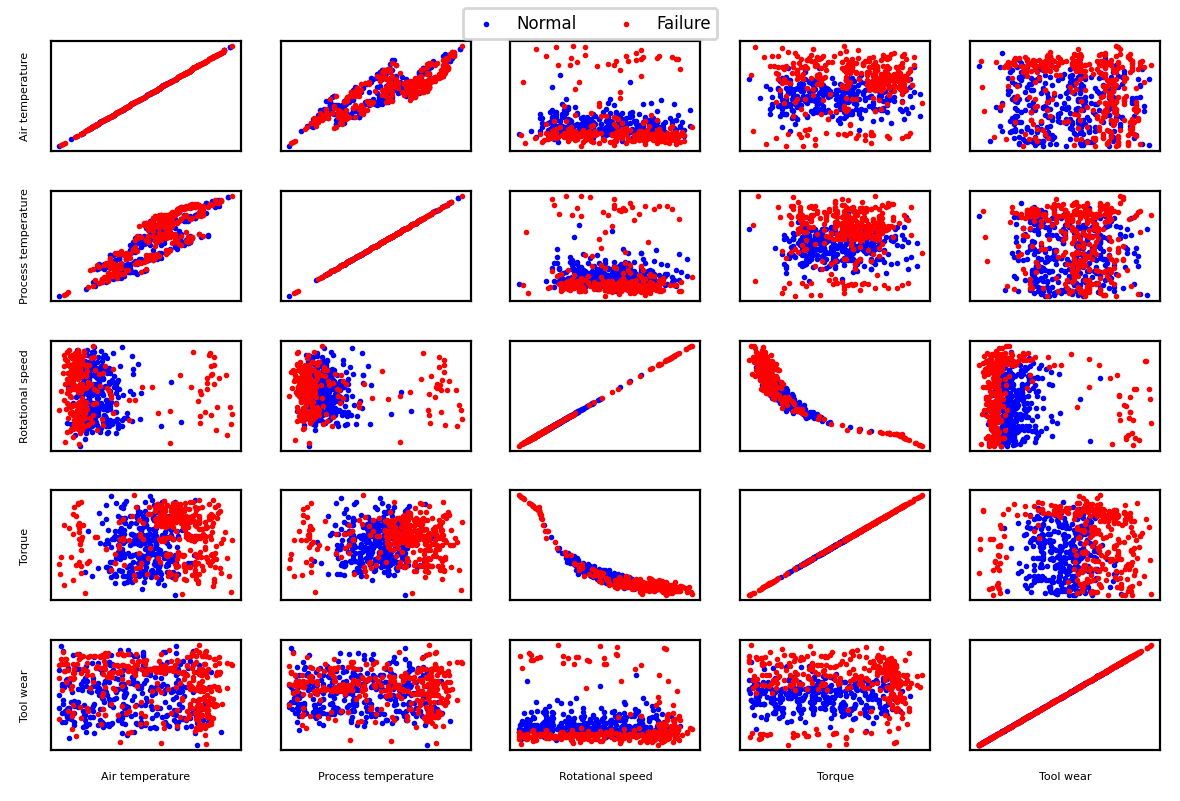

In [83]:
plt.figure(figsize=(6,4), dpi=200)
rows, cols = 5, 5
counter = 1
handle_labels = None
for i in range(3, 8):
    for j in range(3, 8):
        ax = plt.subplot(rows, cols, counter)
        counter += 1

        failures = X_undersample[y_undersample == 1, :]
        normal = X_undersample[y_undersample == 0, :]

        ax.scatter(normal[:,i], normal[:,j], 1, "b", label="Normal")
        ax.scatter(failures[:,i], failures[:,j], 1, "r", label="Failure")
        ax.set_xticks([])
        ax.set_yticks([])
        
        handle_labels = ax.get_legend_handles_labels()

        if i == 7:
            plt.xlabel(" ".join(data.columns[j].split()[:-1]), {"size": 4})
        if j == 3:
            plt.ylabel(" ".join(data.columns[i].split()[:-1]), {"size": 4})

lines, labels = handle_labels
plt.figlegend(lines, labels, loc='upper center', ncol=2, fontsize=6)
plt.tight_layout()

###  MODEL 1: Logistic regression classifier - Undersampled data

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

**Our goal is, do not miss a failure state**, therefore we are interested in the Recall score.

Precision is less important metric for this problem, because if we predict that a machine requires maintanence and turns out not to need it, it is not a massive problem compared to the opposite.

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### K-fold Cross Validation (CV) to find the best hyper-parameter C of Logistic Regression.  

C =1/$\lambda$, where $\lambda$ is the regularization parameter. 

In [85]:
# Find the best hyper-parameter optimizing for recall
def print_gridsearch_scores(x_train_data,y_train_data):

    params = {
        "C": [0.01,0.1,1,10,100],
        "solver": ["lbfgs", "liblinear"]
    }

    clf = GridSearchCV(LogisticRegression(), params, cv=5, scoring='recall')
    clf.fit(x_train_data,y_train_data)

    print("Best parameters found on development set:")
    print()
    print(clf.best_params_)

    print("Grid scores on development set:")
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #Simultaneous visualization of iterations on different arrays
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    return clf.best_params_["solver"], clf.best_params_["C"]

In [86]:
#Apply function print_gridsearch_scores to get the best C with the Undersampled dataset
best_solver, best_c = print_gridsearch_scores(X_train_undersample, y_train_undersample)

Best parameters found on development set:

{'C': 0.1, 'solver': 'liblinear'}
Grid scores on development set:
0.794 (+/-0.049) for {'C': 0.01, 'solver': 'lbfgs'}
0.835 (+/-0.089) for {'C': 0.01, 'solver': 'liblinear'}
0.831 (+/-0.096) for {'C': 0.1, 'solver': 'lbfgs'}
0.852 (+/-0.090) for {'C': 0.1, 'solver': 'liblinear'}
0.827 (+/-0.061) for {'C': 1, 'solver': 'lbfgs'}
0.827 (+/-0.061) for {'C': 1, 'solver': 'liblinear'}
0.827 (+/-0.061) for {'C': 10, 'solver': 'lbfgs'}
0.827 (+/-0.061) for {'C': 10, 'solver': 'liblinear'}
0.827 (+/-0.061) for {'C': 100, 'solver': 'lbfgs'}
0.827 (+/-0.061) for {'C': 100, 'solver': 'liblinear'}


### Model 1.1: Logistic Regression trained with undersampled data


For undersampled train set:
Confusion matrix
[[184  47]
 [ 38 205]]
Recall:  0.8436213991769548

For undersampled test set:
Confusion matrix
[[82 26]
 [16 80]]
Recall:  0.8333333333333334

For whole test set:
Confusion matrix
[[2192  709]
 [  17   82]]
Recall:  0.8282828282828283

For entire dataset:
Confusion matrix
[[7412 2249]
 [  54  285]]
Recall:  0.8407079646017699


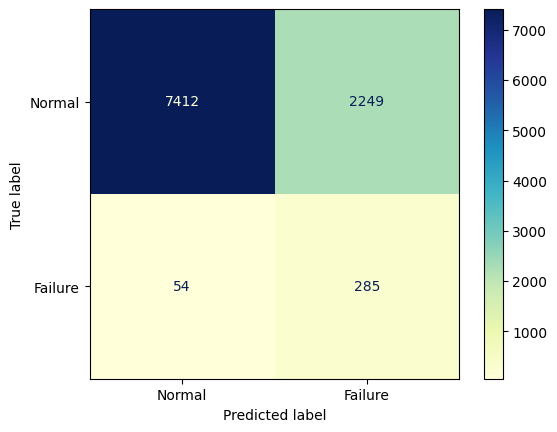

In [87]:
# Use the best C to train LogReg model with undersampled train data and test it
lr = LogisticRegression(C = best_c, solver=best_solver)
lr.fit(X_train_undersample,y_train_undersample)

print("For undersampled train set:")
y_pred_undersample = lr.predict(X_train_undersample)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train_undersample,y_pred_undersample)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


print("\nFor undersampled test set:")
y_pred_undersample = lr.predict(X_test_undersample)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


print("\nFor whole test set:")
y_pred = lr.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


print("\nFor entire dataset:")
y_pred = lr.predict(X)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

cnf_display = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=["Normal", "Failure"], cmap="YlGnBu")
plt.show()

Lower recall score than paper, many more false positives

### MODEL 2: Deep NN model

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.metrics import Recall

In [89]:
# Neural Network (NN) with multiple hidden layers
def network_builder(hidden_dimensions, input_dim):
    
    # create model
    model = Sequential()
    model.add(Dense(hidden_dimensions[0], input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    
    # add multiple hidden layers
    for dimension in hidden_dimensions[1:]:
        model.add(Dense(dimension, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model. Use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[ Recall() ])
    
    return model

In [90]:
# Find the best hyper-parameter (hidden layer dimensions) optimizing for recall
def print_gridsearch_scores_deep_learning(x_train_data,y_train_data, scoring="recall"): 
    
    #choose between several options for "hidden_dimensions": 
    # [10] - 1 hidden layer with 10 units; 
    # [10, 10, 10] - 3 hidden layers with 10 units each; 
    # [100, 10] - 2 hidden layers with 10o units the 1st and 10 units the 2nd layer
    # etc...
    
    parameters = {
        "hidden_dimensions": [
            #[5],
            #[5, 5],
            [10],
            [10, 10, 10],
            [100, 10],
            [100, 10, 10],
            [100, 100, 10]
        ]
    }

    clf = GridSearchCV(KerasClassifier(build_fn=network_builder, epochs=500, batch_size=128, 
        verbose=0, input_dim=x_train_data.shape[1]), parameters, cv=5, scoring=scoring)
    
    clf.fit(x_train_data,y_train_data)

    print("Best parameters found on development set:")
    print()
    print(clf.best_params_)

    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print( "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params) )


In [91]:
print_gridsearch_scores_deep_learning(X_train_undersample, y_train_undersample)

3/3 [==============================] - 0s 2ms/step
Best parameters found on development set:

{'hidden_dimensions': [100, 10]}
Grid scores on development set:
0.885 (+/-0.095) for {'hidden_dimensions': [10]}
0.919 (+/-0.077) for {'hidden_dimensions': [10, 10, 10]}
0.921 (+/-0.069) for {'hidden_dimensions': [100, 10]}
0.913 (+/-0.096) for {'hidden_dimensions': [100, 10, 10]}
0.917 (+/-0.059) for {'hidden_dimensions': [100, 100, 10]}


### Choosing number of epochs for NN

The NN classifier seems to perform well with both layer sizes [100, 10] and [100, 100, 10]. Let's plot the cost function over the number of epochs for both, to determine when each is done training.

In [92]:
input_dim = X_train_undersample.shape[1]

k1 = KerasClassifier(build_fn=network_builder, epochs=2500, batch_size=128,
                     hidden_dimensions=[100, 10], verbose=0, input_dim=input_dim)

k2 = KerasClassifier(build_fn=network_builder, epochs=900, batch_size=128,
                     hidden_dimensions=[100, 100, 10], verbose=0, input_dim=input_dim)

hist1 = k1.fit(X_train_undersample,y_train_undersample).history
hist2 = k2.fit(X_train_undersample,y_train_undersample).history

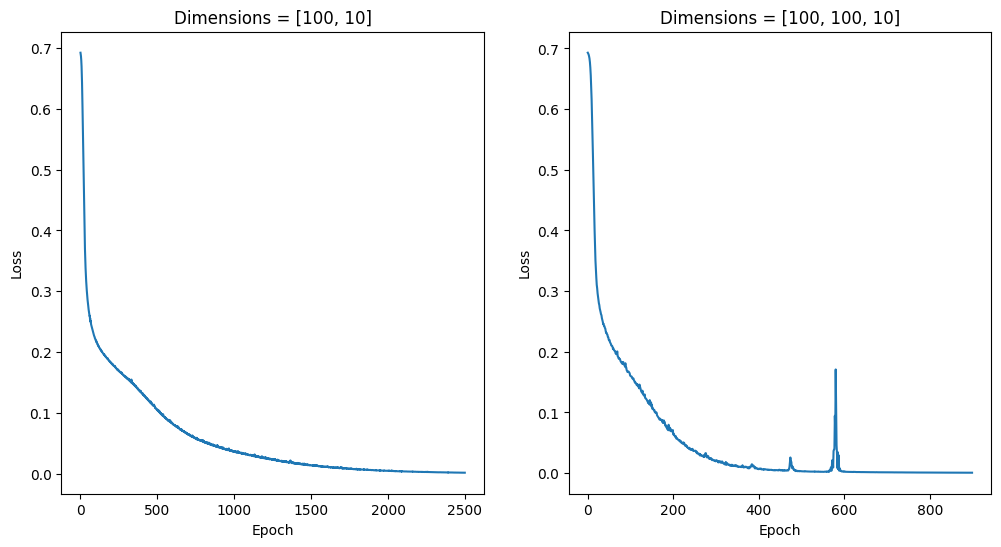

In [93]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(hist1["loss"], label="Loss")
plt.title("Dimensions = [100, 10]")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(hist2["loss"], label="Loss")
plt.title("Dimensions = [100, 100, 10]")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

The NN finishes training much earlier with dimensions [100, 100, 10], at around 800 epochs, as opposed to the 2500 of the other set of parameters.

313/313 [==============================] - 0s 868us/step
Recall:  0.9852507374631269


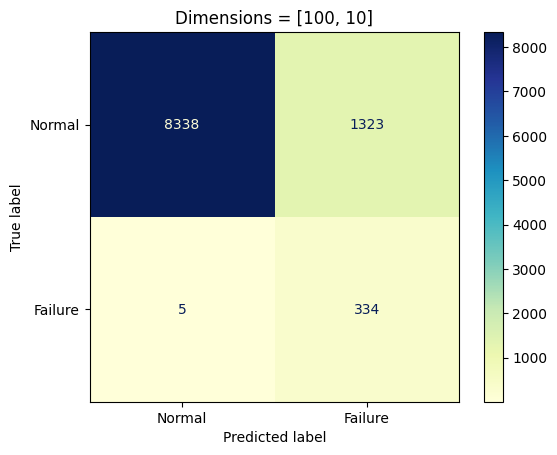

313/313 [==============================] - 0s 1ms/step
Recall:  0.976401179941003


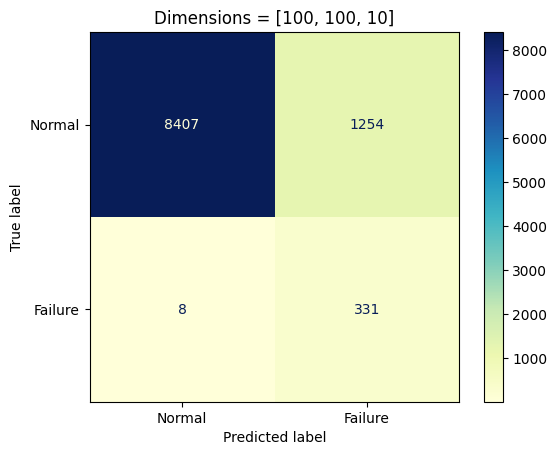

In [94]:
y_pred1 = k1.predict(X)
cnf_matrix = confusion_matrix(y, y_pred1)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
cnf_display = ConfusionMatrixDisplay.from_predictions(y, y_pred1, display_labels=["Normal", "Failure"], cmap="YlGnBu")
plt.title("Dimensions = [100, 10]")
plt.show()

y_pred2 = k2.predict(X)
cnf_matrix = confusion_matrix(y, y_pred2)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
cnf_display = ConfusionMatrixDisplay.from_predictions(y, y_pred2, display_labels=["Normal", "Failure"], cmap="YlGnBu")
plt.title("Dimensions = [100, 100, 10]")
plt.show()

Testing both NNs on the whole dataset, they obtain very close recall rates, with very minor variance.

Using dimensions [100, 100, 10] seems preferable as results are near identical with less training required.

### Train and test NN model with best dimension parameters

For undersampled train set:
15/15 [==============================] - 0s 1ms/step
Confusion matrix
[[218  13]
 [ 10 233]]
Recall:  0.9588477366255144

For undersampled test set:
7/7 [==============================] - 0s 2ms/step
Confusion matrix
[[94 14]
 [ 7 89]]
Recall:  0.9270833333333334

For whole test set:
94/94 [==============================] - 0s 963us/step
Confusion matrix
[[2454  447]
 [   8   91]]
Recall:  0.9191919191919192

For entire dataset:
313/313 [==============================] - 0s 960us/step
Confusion matrix
[[8274 1387]
 [  17  322]]
Recall:  0.9498525073746312


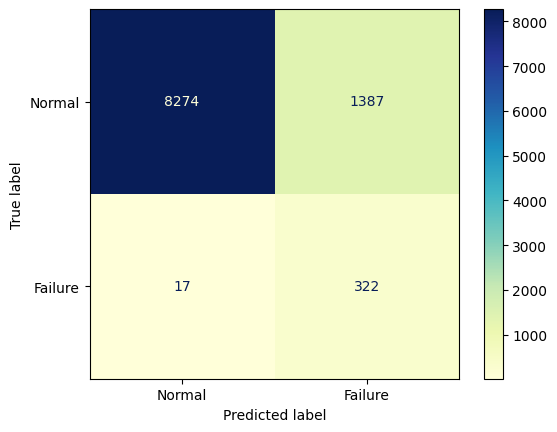

In [95]:
# Use the best hidden_dimension to train and Deep NN model with the under-sample data and test it

input_dim = X_train_undersample.shape[1]

k = KerasClassifier(build_fn=network_builder, epochs=100, batch_size=128,
                     hidden_dimensions=[100, 100, 10], verbose=0, input_dim=input_dim)
k.fit(X_train_undersample,y_train_undersample)



print("For undersampled train set:")
y_pred_undersample = k.predict(X_train_undersample)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train_undersample,y_pred_undersample)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


print("\nFor undersampled test set:")
y_pred_undersample = k.predict(X_test_undersample)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


print("\nFor whole test set:")
y_pred = k.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


print("\nFor entire dataset:")
y_pred = k.predict(X)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cnf_matrix)
print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

cnf_display = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=["Normal", "Failure"], cmap="YlGnBu")
plt.show()

Much higher recall, less false positives (though still considerably more than the paper's classifier)